# Gradient Distribution
> 7강에서 잠깐 소개되었던 그래디언트 분포 시각화입니다. 이번 시각화를 위해 베이스라인 코드에서 수정할 부분을 알려드리고 시각화 코드와 설명을 제공합니다. 사용하고 계시는 모델에 직접 적용해보고 결과를 눈으로 확인해보세요 :)! 

## 베이스라인
> 처음에 주어지는 노트북 베이스라인 코드입니다!

In [ ]:
!pip install easydict

In [ ]:
import pandas as pd
import os
import torch
import easydict
import numpy as np
from sklearn.preprocessing import LabelEncoder
import time
import datetime
from datetime import datetime
import random

### 1. 데이터 로드 및 전처리 컴포넌트

In [ ]:
import os
import random
import time
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import tqdm
from sklearn.preprocessing import LabelEncoder


class Preprocess:
    def __init__(self, args):

        self.args = args
        self.train_data = None
        self.test_data = None

    def get_train_data(self):
        return self.train_data

    def get_test_data(self):
        return self.test_data

    def split_data(self, data, ratio=0.7, shuffle=True, seed=0):
        """
        split data into two parts with a given ratio.
        """
        if shuffle:
            random.seed(seed)  # fix to default seed 0
            random.shuffle(data)

        size = int(len(data) * ratio)
        data_1 = data[:size]
        data_2 = data[size:]

        return data_1, data_2

    def __save_labels(self, encoder, name):
        le_path = os.path.join(self.args.asset_dir, name + "_classes.npy")
        np.save(le_path, encoder.classes_)

    def __preprocessing(self, df, is_train=True):
        cate_cols = ["assessmentItemID", "testId", "KnowledgeTag"]

        if not os.path.exists(self.args.asset_dir):
            os.makedirs(self.args.asset_dir)

        for col in cate_cols:

            le = LabelEncoder()
            if is_train:
                # For UNKNOWN class
                a = df[col].unique().tolist() + ["unknown"]
                le.fit(a)
                self.__save_labels(le, col)
            else:
                label_path = os.path.join(self.args.asset_dir, col + "_classes.npy")
                le.classes_ = np.load(label_path)

                df[col] = df[col].apply(
                    lambda x: x if str(x) in le.classes_ else "unknown"
                )

            # 모든 컬럼이 범주형이라고 가정
            df[col] = df[col].astype(str)
            test = le.transform(df[col])
            df[col] = test

        def convert_time(s):
            timestamp = time.mktime(
                datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()
            )
            return int(timestamp)

        df["Timestamp"] = df["Timestamp"].apply(convert_time)

        return df

    def __feature_engineering(self, df):
        # TODO
        return df

    def load_data_from_file(self, file_name, is_train=True):
        csv_file_path = os.path.join(self.args.data_dir, file_name)
        df = pd.read_csv(csv_file_path)  # , nrows=100000)
        df = self.__feature_engineering(df)
        df = self.__preprocessing(df, is_train)

        # 추후 feature를 embedding할 시에 embedding_layer의 input 크기를 결정할때 사용
        self.args.n_questions = len(
            np.load(os.path.join(self.args.asset_dir, "assessmentItemID_classes.npy"))
        )
        self.args.n_test = len(
            np.load(os.path.join(self.args.asset_dir, "testId_classes.npy"))
        )
        self.args.n_tag = len(
            np.load(os.path.join(self.args.asset_dir, "KnowledgeTag_classes.npy"))
        )

        df = df.sort_values(by=["userID", "Timestamp"], axis=0)
        columns = ["userID", "assessmentItemID", "testId", "answerCode", "KnowledgeTag"]
        group = (
            df[columns]
            .groupby("userID")
            .apply(
                lambda r: (
                    r["testId"].values,
                    r["assessmentItemID"].values,
                    r["KnowledgeTag"].values,
                    r["answerCode"].values,
                )
            )
        )

        return group.values

    def load_train_data(self, file_name):
        self.train_data = self.load_data_from_file(file_name)

    def load_test_data(self, file_name):
        self.test_data = self.load_data_from_file(file_name, is_train=False)

### 2. 데이터 셋 / 데이터 로더

In [ ]:
class DKTDataset(torch.utils.data.Dataset):
    def __init__(self, data, args):
        
        self.data = data
        self.args = args

    def __getitem__(self, index):

        row = self.data[index]

        # 각 data의 sequence length
        seq_len = len(row[0])

        test, question, tag, correct = row[0], row[1], row[2], row[3]
        cate_cols = [test, question, tag, correct]

        # max seq len을 고려하여서 이보다 길면 자르고 아닐 경우 그대로 냅둔다
        if seq_len > self.args.max_seq_len:
            for i, col in enumerate(cate_cols):
                cate_cols[i] = col[-self.args.max_seq_len :]
            mask = np.ones(self.args.max_seq_len, dtype=np.int16)
        else:
            mask = np.zeros(self.args.max_seq_len, dtype=np.int16)
            mask[-seq_len:] = 1

        # mask도 columns 목록에 포함시킴
        cate_cols.append(mask)

        # np.array -> torch.tensor 형변환
        for i, col in enumerate(cate_cols):
            cate_cols[i] = torch.tensor(col)

        return cate_cols

    def __len__(self):
        return len(self.data)


def collate(batch):
    col_n = len(batch[0])
    col_list = [[] for _ in range(col_n)]
    max_seq_len = len(batch[0][-1])

    # batch의 값들을 각 column끼리 그룹화
    for row in batch:
        for i, col in enumerate(row):
            pre_padded = torch.zeros(max_seq_len)
            pre_padded[-len(col) :] = col
            col_list[i].append(pre_padded)

    for i, _ in enumerate(col_list):
        col_list[i] = torch.stack(col_list[i])

    return tuple(col_list)


def get_loaders(args, train, valid):

    pin_memory = False
    train_loader, valid_loader = None, None

    if train is not None:
        trainset = DKTDataset(train, args)
        train_loader = torch.utils.data.DataLoader(
            trainset,
            num_workers=args.num_workers,
            shuffle=True,
            batch_size=args.batch_size,
            pin_memory=pin_memory,
            collate_fn=collate,
        )
    if valid is not None:
        valset = DKTDataset(valid, args)
        valid_loader = torch.utils.data.DataLoader(
            valset,
            num_workers=args.num_workers,
            shuffle=False,
            batch_size=args.batch_size,
            pin_memory=pin_memory,
            collate_fn=collate,
        )

    return train_loader, valid_loader

### 3. LSTM 기반의 모델

In [ ]:
import torch
import torch.nn as nn


class LSTM(nn.Module):
    def __init__(self, args):

        super(LSTM, self).__init__()
        self.args = args
        self.device = args.device

        self.hidden_dim = self.args.hidden_dim
        self.n_layers = self.args.n_layers

        # Embedding
        # interaction은 현재 correct로 구성되어있다. correct(1, 2) + padding(0)
        self.embedding_interaction = nn.Embedding(3, self.hidden_dim // 3)
        self.embedding_test = nn.Embedding(self.args.n_test + 1, self.hidden_dim // 3)
        self.embedding_question = nn.Embedding(
            self.args.n_questions + 1, self.hidden_dim // 3
        )
        self.embedding_tag = nn.Embedding(self.args.n_tag + 1, self.hidden_dim // 3)

        # embedding combination projection
        self.comb_proj = nn.Linear((self.hidden_dim // 3) * 4, self.hidden_dim)

        self.lstm = nn.LSTM(
            self.hidden_dim, self.hidden_dim, self.n_layers, batch_first=True
        )

        # Fully connected layer
        self.fc = nn.Linear(self.hidden_dim, 1)
        self.activation = nn.Sigmoid()

    def init_hidden(self, batch_size):

        h = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        h = h.to(self.device)

        c = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        c = c.to(self.device)

        return (h, c)

    def forward(self, input):

        test, question, tag, _, mask, interaction = input
        batch_size = interaction.size(0)

        # Embedding
        embed_interaction = self.embedding_interaction(interaction)
        embed_test = self.embedding_test(test)
        embed_question = self.embedding_question(question)
        embed_tag = self.embedding_tag(tag)

        embed = torch.cat(
            [
                embed_interaction,
                embed_test,
                embed_question,
                embed_tag,
            ],
            2,
        )

        X = self.comb_proj(embed)

        hidden = self.init_hidden(batch_size)
        out, hidden = self.lstm(X, hidden)
        out = out.contiguous().view(batch_size, -1, self.hidden_dim)
        out = self.fc(out)
        preds = self.activation(out).view(batch_size, -1)

        return preds


### 4. 모델 훈련을 위한 함수들

In [ ]:
import os, sys

import numpy as np

import tarfile
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW

from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import get_linear_schedule_with_warmup
from transformers import get_cosine_schedule_with_warmup

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import scipy.stats


# 훈련을 하기 위한 세팅
def get_optimizer(model, args):
    if args.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=0.01)
    if args.optimizer == "adamW":
        optimizer = AdamW(model.parameters(), lr=args.lr, weight_decay=0.01)

    # 모든 parameter들의 grad값을 0으로 초기화
    optimizer.zero_grad()

    return optimizer


def get_scheduler(optimizer, args):
    if args.scheduler == "plateau":
        scheduler = ReduceLROnPlateau(
            optimizer, patience=10, factor=0.5, mode="max", verbose=True
        )
    elif args.scheduler == "linear_warmup":
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=args.warmup_steps,
            num_training_steps=args.total_steps,
        )
    return scheduler


def get_criterion(pred, target):
    loss = nn.BCELoss(reduction="none")
    return loss(pred, target)


def get_metric(targets, preds):
    auc = roc_auc_score(targets, preds)
    acc = accuracy_score(targets, np.where(preds >= 0.5, 1, 0))

    return auc, acc

def get_model(args):
    """
    Load model and move tensors to a given devices.
    """
    if args.model == 'lstm':
        model = LSTM(args)
    model.to(args.device)

    return model


# 배치 전처리
def process_batch(batch, args):

    test, question, tag, correct, mask = batch

    # change to float
    mask = mask.type(torch.FloatTensor)
    correct = correct.type(torch.FloatTensor)

    # interaction을 임시적으로 correct를 한칸 우측으로 이동한 것으로 사용
    interaction = correct + 1  # 패딩을 위해 correct값에 1을 더해준다.
    interaction = interaction.roll(shifts=1, dims=1)
    interaction_mask = mask.roll(shifts=1, dims=1)
    interaction_mask[:, 0] = 0
    interaction = (interaction * interaction_mask).to(torch.int64)

    test = ((test + 1) * mask).to(torch.int64)
    question = ((question + 1) * mask).to(torch.int64)
    tag = ((tag + 1) * mask).to(torch.int64)

    # device memory로 이동
    test = test.to(args.device)
    question = question.to(args.device)
    tag = tag.to(args.device)
    correct = correct.to(args.device)
    mask = mask.to(args.device)

    interaction = interaction.to(args.device)

    return (test, question, tag, correct, mask, interaction)


# loss계산하고 parameter update!
def compute_loss(preds, targets):

    """
    Args :
        preds   : (batch_size, max_seq_len)
        targets : (batch_size, max_seq_len)

    """

    loss = get_criterion(preds, targets)
    # 마지막 시퀀드에 대한 값만 loss 계산
    loss = loss[:, -1]
    loss = torch.mean(loss)
    return loss


def update_params(loss, model, optimizer, scheduler, args):
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_grad)
    if args.scheduler == "linear_warmup":
        scheduler.step()
    optimizer.step()
    optimizer.zero_grad()


def save_checkpoint(state, model_dir, model_filename):
    print('saving model ...')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)    
    torch.save(state, os.path.join(model_dir, model_filename))


def load_model(args):

    model_path = os.path.join(args.model_dir, args.model_name)
    print("Loading Model from:", model_path)
    load_state = torch.load(model_path)
    model = get_model(args)

    # 1. load model state
    model.load_state_dict(load_state["state_dict"], strict=True)

    print("Loading Model from:", model_path, "...Finished.")
    return model

### 5. 전체 프로세스를 담당하는 함수들

In [ ]:
def train(train_loader, model, optimizer, scheduler, args):
    model.train()

    total_preds = []
    total_targets = []
    losses = []
    for step, batch in enumerate(train_loader):
        input = process_batch(batch, args)
        preds = model(input)
        targets = input[3]  # correct

        loss = compute_loss(preds, targets)
        update_params(loss, model, optimizer, scheduler, args)

        if step % args.log_steps == 0:
            print(f"Training steps: {step} Loss: {str(loss.item())}")

        # predictions
        preds = preds[:, -1]
        targets = targets[:, -1]

        if args.device == "cuda":
            preds = preds.to("cpu").detach().numpy()
            targets = targets.to("cpu").detach().numpy()
        else:  # cpu
            preds = preds.detach().numpy()
            targets = targets.detach().numpy()

        total_preds.append(preds)
        total_targets.append(targets)
        losses.append(loss)

    total_preds = np.concatenate(total_preds)
    total_targets = np.concatenate(total_targets)

    # Train AUC / ACC
    auc, acc = get_metric(total_targets, total_preds)
    loss_avg = sum(losses) / len(losses)
    print(f"TRAIN AUC : {auc} ACC : {acc}")
    return auc, acc, loss_avg
    

def validate(valid_loader, model, args):
    model.eval()

    total_preds = []
    total_targets = []
    for step, batch in enumerate(valid_loader):
        input = process_batch(batch, args)

        preds = model(input)
        targets = input[3]  # correct

        # predictions
        preds = preds[:, -1]
        targets = targets[:, -1]

        if args.device == "cuda":
            preds = preds.to("cpu").detach().numpy()
            targets = targets.to("cpu").detach().numpy()
        else:  # cpu
            preds = preds.detach().numpy()
            targets = targets.detach().numpy()

        total_preds.append(preds)
        total_targets.append(targets)

    total_preds = np.concatenate(total_preds)
    total_targets = np.concatenate(total_targets)

    # Train AUC / ACC
    auc, acc = get_metric(total_targets, total_preds)

    print(f"VALID AUC : {auc} ACC : {acc}\n")

    return auc, acc


def inference(args, test_data):

    model = load_model(args)
    model.eval()
    _, test_loader = get_loaders(args, None, test_data)

    total_preds = []

    for step, batch in enumerate(test_loader):
        input = process_batch(batch, args)

        preds = model(input)

        # predictions
        preds = preds[:, -1]

        if args.device == "cuda":
            preds = preds.to("cpu").detach().numpy()
        else:  # cpu
            preds = preds.detach().numpy()

        total_preds += list(preds)

    write_path = os.path.join(args.output_dir, "output.csv")
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)
    with open(write_path, "w", encoding="utf8") as w:
        w.write("id,prediction\n")
        for id, p in enumerate(total_preds):
            w.write("{},{}\n".format(id, p))

In [ ]:
# 경로는 사용자가 직접 맞춰서 수정해주세요!
data_dir = '/opt/ml/input/data/train_dataset'
file_name = 'train_data.csv'
test_file_name = 'test_data.csv'

config = {}

# 설정
config['seed'] = 42
config['device'] = "cuda" if torch.cuda.is_available() else "cpu"
config['data_dir'] = data_dir
config['asset_dir'] = 'asset'
config['model_dir'] = 'models'
config['model_name'] = 'model.pt'
config['output_dir'] = 'output'

# 데이터
config['max_seq_len'] = 20
config['num_workers'] = 1


# 모델
config['hidden_dim'] = 64
config['n_layers'] = 2
config['dropout'] = 0.2

# 훈련
config['n_epochs'] = 20
config['batch_size'] = 64
config['lr'] = 0.0001
config['clip_grad'] = 10
config['log_steps'] = 50
config['patience'] = 5



### 중요 ###
config['model'] = 'lstm'
config['optimizer'] = 'adam'
config['scheduler'] = 'plateau'


args = easydict.EasyDict(config)

## 베이스라인 수정 사항

> 시각화를 위해 베이스라인 코드의 어떤 부분을 수정해야 하는지 알아봅시다!

- get_gradient
- train
- run

### get_gradient
> 모델의 parameter들에서 gradient 값 가져오는 함수 추가

In [ ]:
def get_gradient(model):
    gradient = []

    for name, param in model.named_parameters():
        grad = param.grad
        if grad != None:
            gradient.append(grad.cpu().numpy().astype(np.float16))
            # gradient.append(grad.clone().detach())
        else:
            gradient.append(None)

    return gradient

### train

- **수정사항 : 함수에 gradient 인자 추가**

```python
before : def train(train_loader, model, optimizer, args):
after  : def train(train_loader, model, optimizer, args, gradient=False):
```

- **수정 및 추가사항 : update_params 내용을 train으로 이동 후 삭제 및 iteration마다 gradient 프로세스 추가**

```python
### before ### 
loss = compute_loss(preds, targets)
update_params(loss, model, optimizer, args)

### after ### 
loss = compute_loss(preds, targets, index)
loss.backward()

# save gradient distribution
if gradient:
    args.n_iteration += 1
    args.gradient[f'iteration_{args.n_iteration}'] = get_gradient(model)

torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_grad)
optimizer.step()
optimizer.zero_grad()
```

In [ ]:
def train(train_loader, model, optimizer, args, gradient=False):
    model.train()

    total_preds = []
    total_targets = []
    losses = []
    for step, batch in enumerate(train_loader):
        input = process_batch(batch, args)
        preds = model(input)
        targets = input[3] # correct

        loss = compute_loss(preds, targets)
        loss.backward()
        
        ######################################### 추가되는 부분 #########################
        # save gradient distribution
        if gradient:
            args.n_iteration += 1
            args.gradient[f'iteration_{args.n_iteration}'] = get_gradient(model)
        ###############################################################################

        torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_grad)
        optimizer.step()
        optimizer.zero_grad()

        if step % args.log_steps == 0:
            print(f"Training steps: {step} Loss: {str(loss.item())}")
        
        # predictions
        preds = preds[:,-1]
        targets = targets[:,-1]

        if args.device == 'cuda':
            preds = preds.to('cpu').detach().numpy()
            targets = targets.to('cpu').detach().numpy()
        else: # cpu
            preds = preds.detach().numpy()
            targets = targets.detach().numpy()
        
        total_preds.append(preds)
        total_targets.append(targets)
        losses.append(loss)
      

    total_preds = np.concatenate(total_preds)
    total_targets = np.concatenate(total_targets)

    # Train AUC / ACC
    auc, acc = get_metric(total_targets, total_preds)
    loss_avg = sum(losses)/len(losses)
    print(f'TRAIN AUC : {auc} ACC : {acc}')
    return auc, acc, loss_avg

### run

- **수정사항 1 : 함수에 gradient 인자 추가**

```python
before : def run(args, train_data, valid_data):
after  : def run(args, train_data, valid_data, gradient=False):
```

- **수정사항 2 : train함수 호출 시 gradient 인자 넘기기**

```python
before : train_auc, train_acc, train_loss = train(train_loader, model, optimizer, args)
after  : train_auc, train_acc, train_loss = train(train_loader, model, optimizer, args, gradient)
```

- **추가사항 1 : OrderedDict import**

```python
from collections import OrderedDict
```

- **추가사항 2 : args에 gradient 값 저장 준비**

```python
# 🌟 분석에 사용할 값 저장 🌟
report = OrderedDict()

# gradient step 분석에 사용할 변수
if gradient:
    args.n_iteration = 0
    args.gradient = OrderedDict()

    # 모델의 gradient값을 가리키는 모델 명 저장
    args.gradient['name'] = [name for name, _ in model.named_parameters()]
```

- **추가사항 3 : gradient값 args에서 report로 옮겨 return 하기**

```python
# 🌟 분석에 사용할 값 저장 🌟
# save gradient informations
if gradient:
    report['gradient'] = args.gradient
    del args.gradient
    del args['gradient']

    return report
```

In [ ]:
from collections import OrderedDict

def run(args, train_data, valid_data, gradient=False):
    train_loader, valid_loader = get_loaders(args, train_data, valid_data)
    
    # only when using warmup scheduler
    args.total_steps = int(len(train_loader.dataset) / args.batch_size) * (args.n_epochs)
    args.warmup_steps = args.total_steps // 10
            
    model = get_model(args)
    optimizer = get_optimizer(model, args)
    scheduler = get_scheduler(optimizer, args)
    
    ######################################### 추가되는 부분 #########################
    # 🌟 분석에 사용할 값 저장 🌟
    report = OrderedDict()

    # gradient step 분석에 사용할 변수
    if gradient:
        args.n_iteration = 0
        args.gradient = OrderedDict()

        # 모델의 gradient값을 가리키는 모델 명 저장
        args.gradient['name'] = [name for name, _ in model.named_parameters()]
    ###############################################################################

    best_auc = -1
    early_stopping_counter = 0
    for epoch in range(args.n_epochs):

        print(f"Start Training: Epoch {epoch + 1}")
        
        ### TRAIN
        train_auc, train_acc, train_loss = train(train_loader, model, optimizer, args, gradient)
        
        ### VALID
        auc, acc = validate(valid_loader, model, args)


        if auc > best_auc:
            best_auc = auc
            # torch.nn.DataParallel로 감싸진 경우 원래의 model을 가져옵니다.
            model_to_save = model.module if hasattr(model, 'module') else model
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model_to_save.state_dict(),
                },
                args.model_dir, 'model.pt',
            )
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= args.patience:
                print(f'EarlyStopping counter: {early_stopping_counter} out of {args.patience}')
                break

        # scheduler
        if args.scheduler == 'plateau':
            scheduler.step(best_auc)
        else:
            scheduler.step()

    ######################################### 추가되는 부분 #########################
    # save gradient informations
    if gradient:
        report['gradient'] = args.gradient
        del args.gradient
        del args['gradient']
        
        return report
    ###############################################################################

## 🥚 🌟 그래디언트 분포 시각화 (Gradient Distribution Visualization) 🌟
> 그래디언트 분포의 변화를 살펴보기 위한 커스텀 함수입니다

- flatten_gradient
- abs_log_gradient
- sample_gradient
- filter_gradient
- preprocess_one_iteration
- preprocess_all_iteration
- one_iter_to_df
- all_iter_to_df
- visualize_one_iter_grad_dist
- visualize_all_iter_grad_dist
- 🌟 gradient_distribution 🌟

### flatten_gradient

In [ ]:
def flatten_gradient(grad):
    flatten_grad = []

    for module_grad in grad:
        if not isinstance(module_grad, np.ndarray):
            continue

        flatten_grad.append(module_grad.ravel())
    
    # 각 module들의 gradient들을 한줄로 합친다
    flatten_grad = np.concatenate(flatten_grad)
    
    return flatten_grad

### abs_log_gradient

In [ ]:
def abs_log_gradient(grad):
    # log scale을 취해야하는데 음수가 허용이 안되기 때문에 양수로 변환
    grad = np.absolute(grad)

    # log 10
    grad = np.log10(grad)

    # 값이 너무 작아 -inf가 된 값을 -20으로 바꾼다
    grad = np.where(grad == -float('Inf'), -20., grad) 

    return grad

### sample_gradient

In [ ]:
def sample_gradient(grad, sample_n):
    # 샘플링하고자 하느나 수가 존재하는 gradient 수보다 많으면 샘플링을 하지 않는다
    if sample_n == None or len(grad) < sample_n:
        return grad

    return np.random.choice(grad, sample_n)

### filter_gradient

In [ ]:
def filter_gradient(grad, module_idx):
    if not module_idx:
        return grad

    new_grad = []
    for i, module_grad in enumerate(grad):
        if i + 1 in module_idx:
            new_grad.append(module_grad)
    
    return new_grad

### preprocess_one_iteration

In [ ]:
def preprocess_one_iteration(report,
                             iteration_id,
                             module_idx=None,
                             sample_n=None):
    """iteration_idx : 분석을 원하는 iteration 지정"""

    iterations_len = len(report['gradient']) - 1

    if iteration_id < 1 or iteration_id > iterations_len:
        raise ValueError(f'iteration_idx should be {1} <= iteration_idx <= {iterations_len}')
    
    modules = report['gradient'][f'iteration_{iteration_id}']
    module_names = report['gradient']['name']

    grads = OrderedDict()
    for i, (module_name, module) in enumerate(zip(module_names, modules)):
        if not isinstance(module, np.ndarray):
            continue

        # 원하는 module만 필터링
        module_id = i + 1
        if module_idx and module_id not in module_idx:
            continue

        grad = module

        # 분포 계산해야하므로 주어진 모든 gradient값들을 1d로 flatten
        grad = grad.ravel()

        # 백만개가 넘어가는 gradient값들 전부 다 고려하여 그릴수는 없으니 샘플링
        grad = sample_gradient(grad, sample_n)
        
        # 양수 변환 및 로그 스케일
        grad = abs_log_gradient(grad)

        # 전처리 마친 데이터는 차곡차곡 저장
        grads[module_name] = grad

    return grads

### preprocess_all_iteration

In [ ]:
def preprocess_all_iteration(report,
                             iteration_idx=None,
                             module_idx=None,
                             sample_n=None):
    """
    iteration_idx : 특정 iteration의 gradient만 사용
    module_idx : 특정 module의 gradient만 사용
    sample_n : 각 iteration마다 총 몇개의 gradient를 사용할 것인지
    """
    # iteration key 이름
    iterations = list(report['gradient'].keys())[1:]

    # index
    if not iteration_idx:
        iteration_idx = [i + 1 for i in range(len(iterations))]

    grads = OrderedDict()
    for i, iteration in enumerate(iterations):
        if i + 1 not in iteration_idx:
            continue

        grad = report['gradient'][iteration]

        # 특정 module gradient 분포만 체크
        grad = filter_gradient(grad, module_idx)

        # 분포 계산해야하므로 주어진 모든 gradient값들을 1d로 flatten
        grad = flatten_gradient(grad)

        # 백만개가 넘어가는 gradient값들 전부 다 고려하여 그릴수는 없으니 샘플링
        grad = sample_gradient(grad, sample_n)
        
        # 양수 변환 및 로그 스케일
        grad = abs_log_gradient(grad)

        # 전처리 마친 데이터는 차곡차곡 저장
        grads[i + 1] = grad

    return grads

### one_iter_to_df

In [ ]:
def one_iter_to_df(grads):
    """
    seaborn을 사용하기 위해 pandas DataFrame으로 변환
    """
    grad_df = pd.DataFrame.from_dict(grads, orient='index')
    grad_df = grad_df.reset_index()
    grad_df = grad_df.rename(columns={'index': 'module'})

    # 각 iteration의 gradient정보들을 한 column으로 melt
    grad_df = grad_df.melt(id_vars='module', value_name='gradient')
    grad_df = grad_df.sort_values('module')
    grad_df = grad_df.drop(columns='variable').reset_index(drop=True)
    grad_df = grad_df.dropna()

    # overflow 방지용 데이터 타입 변환
    grad_df['gradient'] = grad_df.gradient.astype(np.float32)

    return grad_df

### all_iter_to_df

In [ ]:
def all_iter_to_df(grads):
    """
    seaborn을 사용하기 위해 pandas DataFrame으로 변환
    """
    # iteration 정보 추가
    grad_df = pd.DataFrame(grads).T
    grad_df = grad_df.reset_index()
    grad_df = grad_df.rename(columns={'index': 'iteration'})

    # 각 iteration의 gradient정보들을 한 column으로 melt
    grad_df = grad_df.melt(id_vars='iteration', value_name='gradient')
    grad_df = grad_df.sort_values('iteration')
    grad_df = grad_df.drop(columns='variable').reset_index(drop=True)

    # overflow 방지용 데이터 타입 변환
    grad_df['gradient'] = grad_df.gradient.astype(np.float32)

    return grad_df

### visualize_one_iter_grad_dist

In [ ]:
def visualize_one_iter_grad_dist(grad_df, filter_module_labels=None):
    # 배경색 지우기
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # 팔레트 색 지정하기
    module_n = grad_df.module.nunique()
    pal = sns.cubehelix_palette(module_n, rot=-.25, light=.7)

    if module_n <= 5:
        height = 2
        aspect = 5
    else:
        height = .5
        aspect = 20

    g = sns.FacetGrid(grad_df,
                      row="module",
                      hue="module",
                      aspect=aspect,
                      height=height,
                      palette=pal)

    # gradient 분포 그리기
    g.map(sns.kdeplot, "gradient",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "gradient", clip_on=False, color="w", lw=1, bw_adjust=.5)
    g.map(plt.axhline, y=0, lw=1.5, clip_on=False)

    if not filter_module_labels:
        filter_module_labels = list(grad_df.module.unique())

    def label(x, color, label):
        ax = plt.gca()

        # 표시하기로 지정한 라벨만 표시하며
        # 지정이 안되어있을시 모든 라벨 표시
        if label not in filter_module_labels:
            return
        ax.text(0, 0.03, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "gradient")

    # 겹쳐서 그리기
    g.fig.subplots_adjust(hspace=-0.9)

    # overlap하며 시각적으로 방해되는 요소 제거
    g.set_titles("")
    g.despine(bottom=True, left=True)

    # x축을 로그스케일로 직접 변경했기 때문에 tick을 직접 지정해준다
    g.set(yticks=[])
    g.set(xticks=[-20, -16, -12, -8, -4, 0])
    g.set_xticklabels(['1e-20', '1e-16', '1e-12', '1e-8', '1e-4', '1'])
    
    g.fig.suptitle('Gradient Distribution')
    plt.ylabel('Iteration')
    plt.show();

### visualize_all_iter_grad_dist

In [ ]:
def visualize_all_iter_grad_dist(grad_df, filter_iteration_labels=None):
    # 배경색 지우기
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # 팔레트 색 지정하기
    iteration_n = grad_df.iteration.nunique()
    pal = sns.cubehelix_palette(iteration_n, rot=-.25, light=.7)

    g = sns.FacetGrid(grad_df,
                      row="iteration",
                      hue="iteration",
                      aspect=20,
                      height=.5,
                      palette=pal)

    # gradient 분포 그리기
    g.map(sns.kdeplot, "gradient",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "gradient", clip_on=False, color="w", lw=1, bw_adjust=.5)
    g.map(plt.axhline, y=0, lw=1.5, clip_on=False)

    if not filter_iteration_labels:
        filter_iteration_labels = list(grad_df.iteration.unique())

    def label(x, color, label):
        ax = plt.gca()

        # 표시하기로 지정한 라벨만 표시하며
        # 지정이 안되어있을시 모든 라벨 표시
        if int(label) not in filter_iteration_labels:
            return
        ax.text(0, 0.03, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "gradient")

    # 겹쳐서 그리기
    g.fig.subplots_adjust(hspace=-0.9)

    # overlap하며 시각적으로 방해되는 요소 제거
    g.set_titles("")
    g.despine(bottom=True, left=True)

    # x축을 로그스케일로 직접 변경했기 때문에 tick을 직접 지정해준다
    g.set(yticks=[])
    g.set(xticks=[-20, -16, -12, -8, -4, 0])
    g.set_xticklabels(['1e-20', '1e-16', '1e-12', '1e-8', '1e-4', '1'])
    
    g.fig.suptitle('Gradient Distribution')
    plt.ylabel('Iteration')
    plt.show();

### 🌟 gradient_distribution 🌟

In [ ]:
def gradient_distribution(report,
                          iteration_idx=None,
                          module_idx=None,
                          sample_n=None,
                          filter_iteration_labels=None,
                          filter_module_labels=None,
                          one_iteration_only=False):
    if one_iteration_only:
        if isinstance(iteration_idx, list):
            if len(iteration_idx) != 1:
                msg = 'Choose only one iteration you want to Analysis. '
                msg += f'Currently {iteration_idx} iteration_idx given'
                raise ValueError(msg)
            else:
                iteration_id = iteration_idx[0]
        elif isinstance(iteration_idx, int):
                iteration_id = iteration_idx
        else:
            raise ValueError("[ iteration_idx ] should be int or list type")
        grads = preprocess_one_iteration(report,
                                         iteration_id=iteration_idx,
                                         module_idx=module_idx,
                                         sample_n=sample_n)
        grad_df = one_iter_to_df(grads)
        visualize_one_iter_grad_dist(grad_df, filter_module_labels)
    else:
        grads = preprocess_all_iteration(report,
                                         iteration_idx=iteration_idx,
                                         module_idx=module_idx,
                                         sample_n=sample_n)

        grad_df = all_iter_to_df(grads)
        visualize_all_iter_grad_dist(grad_df, filter_iteration_labels)
    
    return grad_df

## gradient 분포 시각화하기!
> 위에서 안내된 대로 베이스라인 코드를 수정하고, 시각화 코드를 실행했다면 이제 시각화를 바로 할 수 있습니다!

- 시각화 패키지
- 데이터 불러오기
- 시각화 사용법
- hyperparameter 바꿔가며 사용해보기

In [ ]:
import warnings

warnings.filterwarnings("ignore")

### 시각화 패키지

In [ ]:
!pip install -q seaborn matplotlib

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

### 데이터 불러오기

In [ ]:
preprocess = Preprocess(args)
preprocess.load_train_data(file_name)

train_data = preprocess.get_train_data()
train_data, valid_data = preprocess.split_data(train_data)

In [ ]:
report = run(args, train_data, valid_data, gradient=True)

Start Training: Epoch 1
Training steps: 0 Loss: 0.6918820142745972
Training steps: 50 Loss: 0.6916688084602356
TRAIN AUC : 0.6399752212357108 ACC : 0.5934300341296929
VALID AUC : 0.7272982888359264 ACC : 0.6791044776119403

saving model ...
Start Training: Epoch 2
Training steps: 0 Loss: 0.684679388999939
Training steps: 50 Loss: 0.6807133555412292
TRAIN AUC : 0.7287454633802137 ACC : 0.6802474402730375
VALID AUC : 0.7357341005949848 ACC : 0.6756218905472637

saving model ...
Start Training: Epoch 3
Training steps: 0 Loss: 0.6762704253196716
Training steps: 50 Loss: 0.6720582246780396
TRAIN AUC : 0.7354771188441681 ACC : 0.6845136518771331
VALID AUC : 0.7357043463944357 ACC : 0.6805970149253732

Start Training: Epoch 4
Training steps: 0 Loss: 0.6511883735656738
Training steps: 50 Loss: 0.6374055743217468
TRAIN AUC : 0.7379290131250872 ACC : 0.6862201365187713
VALID AUC : 0.7346758428621158 ACC : 0.6810945273631841

Start Training: Epoch 5
Training steps: 0 Loss: 0.6151856184005737
Trai

In [ ]:
report['gradient']['name']

['embedding_interaction.weight',
 'embedding_test.weight',
 'embedding_question.weight',
 'embedding_tag.weight',
 'comb_proj.weight',
 'comb_proj.bias',
 'lstm.weight_ih_l0',
 'lstm.weight_hh_l0',
 'lstm.bias_ih_l0',
 'lstm.bias_hh_l0',
 'lstm.weight_ih_l1',
 'lstm.weight_hh_l1',
 'lstm.bias_ih_l1',
 'lstm.bias_hh_l1',
 'fc.weight',
 'fc.bias']

### 시각화 사용법

> 이제 `gradient_distribution`과 `report` 두 가지를 사용하여 시각화를 진행할 예정입니다!

**`gradient_distribution` 함수 사용법**
- `one_iteration_only` : bool 타입, 한개의 iteration을 module 단위로 정밀하게 분석할 때 사용합니다
- `iteration_idx` : batch step 각각을 iteration으로 보며, 특정 iteration만 filtering합니다
- `module_idx` : 모델에서 특정 module의 gradient만 사용하도록 filtering합니다
- `sample_n` : 각 그래디언트 분포를 그릴 때 gradient 값들 중에서 몇개를 sampling할지 정합니다

**만약 해당 인자들의 값을 지정하지 않을 시 filtering이 되지 않고 모든 값을 시각화하고자 하기 때문에 시간이 많이 소요됩니다!**

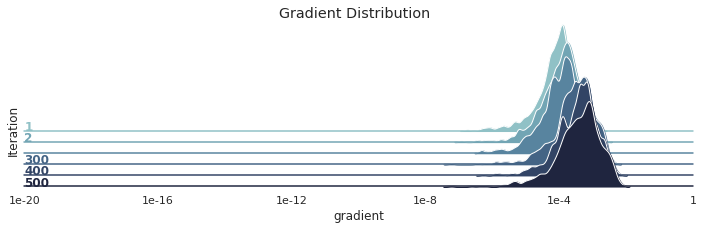

In [ ]:
iteration_idx = [1, 2, 3, 300, 400, 500, 600, 700]
module_idx = [5]
sample_n = 1000
filter_iteration_labels = [1, 2, 300, 400, 500, 600, 700]

grad_df = gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)

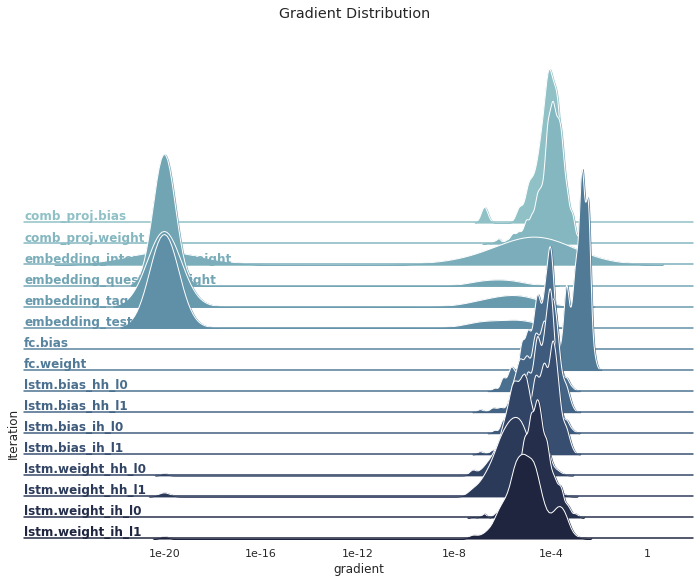

In [ ]:
# 1번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=1, sample_n=1000, one_iteration_only=True)

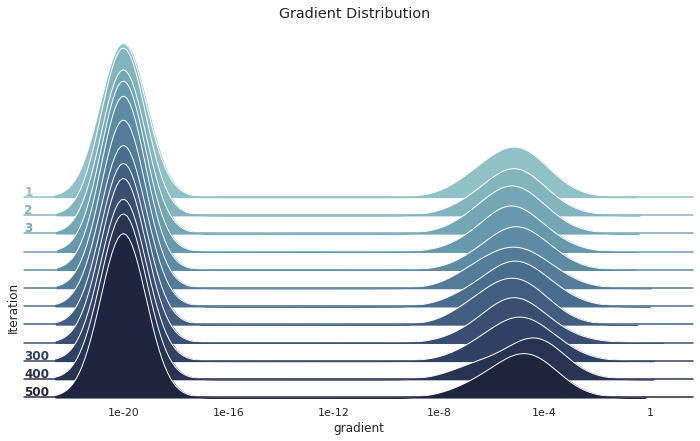

In [ ]:
iteration_idx = [i for i in range(10)] + [300, 400, 500, 600, 700, 820, 1000]
module_idx = []
sample_n = 1000
filter_iteration_labels = [0, 1, 2, 3, 300, 400, 500, 600, 700, 820]

grad_df = gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)

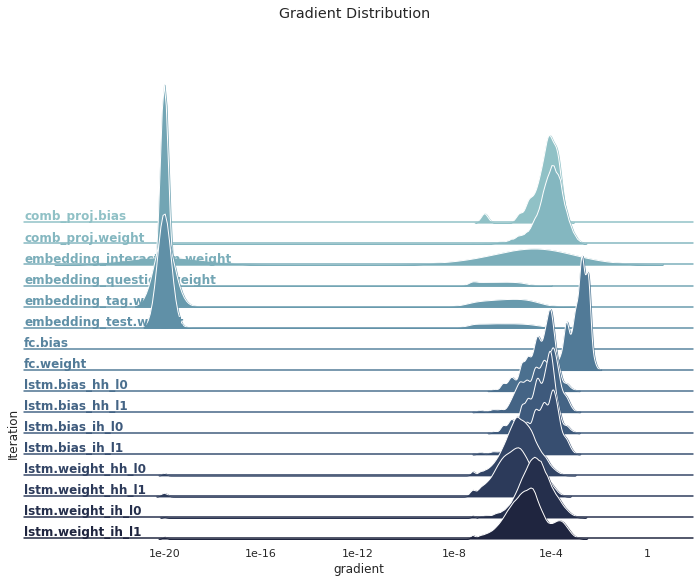

In [ ]:
# 1번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=1, one_iteration_only=True)

### hyperparameter 바꿔가며 사용해보기
> 다양한 실험을 해보며 분포가 어떻게 변화하는지 체크해보세요! 

In [ ]:
# 기본 세팅!
iteration_idx = [1, 2, 3, 300, 400, 500, 600, 700]
module_idx = []
sample_n = 1000
filter_iteration_labels = [1, 2, 300, 400, 500, 600, 700]

In [ ]:
# 세팅 1 - baseline
report = run(args, train_data, valid_data, gradient=True)

Start Training: Epoch 1
Training steps: 0 Loss: 0.6914529204368591
Training steps: 50 Loss: 0.688421905040741
TRAIN AUC : 0.5841466049537473 ACC : 0.523037542662116
VALID AUC : 0.6662401897921273 ACC : 0.5218905472636816

saving model ...
Start Training: Epoch 2
Training steps: 0 Loss: 0.6879916191101074
Training steps: 50 Loss: 0.6859922409057617
TRAIN AUC : 0.6982328492752804 ACC : 0.5398890784982935
VALID AUC : 0.7088348155884241 ACC : 0.5442786069651742

saving model ...
Start Training: Epoch 3
Training steps: 0 Loss: 0.6853762269020081
Training steps: 50 Loss: 0.692072868347168
TRAIN AUC : 0.7206813339690603 ACC : 0.5588737201365188
VALID AUC : 0.7230315364771621 ACC : 0.5706467661691542

saving model ...
Start Training: Epoch 4
Training steps: 0 Loss: 0.6839383840560913
Training steps: 50 Loss: 0.6826783418655396
TRAIN AUC : 0.7309874948377575 ACC : 0.6305460750853242
VALID AUC : 0.7291663567270776 ACC : 0.6502487562189054

saving model ...
Start Training: Epoch 5
Training steps:

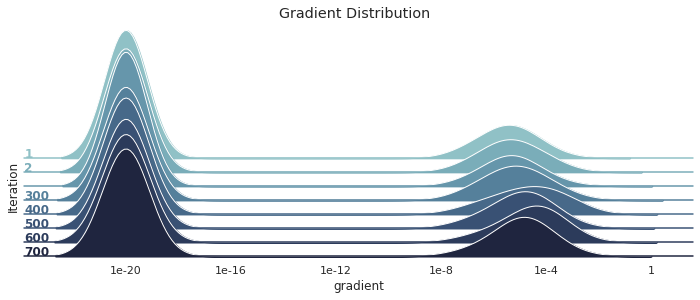

In [ ]:
grad_df = gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)

In [ ]:
# 세팅 2 - n_layers 5로 늘려보기
args.n_layers = 5
report = run(args, train_data, valid_data, gradient=True)

Start Training: Epoch 1
Training steps: 0 Loss: 0.6876286268234253
Training steps: 50 Loss: 0.6999527215957642
TRAIN AUC : 0.48909479108073883 ACC : 0.47888225255972694
VALID AUC : 0.4249395741777178 ACC : 0.4791044776119403

saving model ...
Start Training: Epoch 2
Training steps: 0 Loss: 0.6997441053390503
Training steps: 50 Loss: 0.6941496133804321
TRAIN AUC : 0.4913167661433467 ACC : 0.47888225255972694
VALID AUC : 0.4249341192409505 ACC : 0.4791044776119403

Start Training: Epoch 3
Training steps: 0 Loss: 0.6984308362007141
Training steps: 50 Loss: 0.6926886439323425
TRAIN AUC : 0.49245159343499495 ACC : 0.47888225255972694
VALID AUC : 0.422089617668441 ACC : 0.4791044776119403

Start Training: Epoch 4
Training steps: 0 Loss: 0.6941717863082886
Training steps: 50 Loss: 0.6931562423706055
TRAIN AUC : 0.4893232516521456 ACC : 0.47440273037542663
VALID AUC : 0.41797361992579307 ACC : 0.5208955223880597

Start Training: Epoch 5
Training steps: 0 Loss: 0.6929540038108826
Training steps

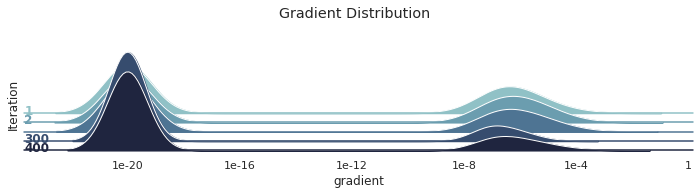

In [ ]:
grad_df = gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)

In [ ]:
# 세팅 2 - lr 바꿔보기
args.n_layers = 2
args.lr = 0.01
report = run(args, train_data, valid_data, gradient=True)

Start Training: Epoch 1
Training steps: 0 Loss: 0.6772983074188232
Training steps: 50 Loss: 0.5315060019493103
TRAIN AUC : 0.7183083889518438 ACC : 0.6702218430034129
VALID AUC : 0.7279543689580377 ACC : 0.672636815920398

saving model ...
Start Training: Epoch 2
Training steps: 0 Loss: 0.595560610294342
Training steps: 50 Loss: 0.6363919973373413
TRAIN AUC : 0.730211585850031 ACC : 0.6802474402730375
VALID AUC : 0.7334425312493491 ACC : 0.6751243781094527

saving model ...
Start Training: Epoch 3
Training steps: 0 Loss: 0.627261221408844
Training steps: 50 Loss: 0.6809648871421814
TRAIN AUC : 0.7325425036033136 ACC : 0.6804607508532423
VALID AUC : 0.7330105994380423 ACC : 0.6810945273631841

Start Training: Epoch 4
Training steps: 0 Loss: 0.6717307567596436
Training steps: 50 Loss: 0.6321182250976562
TRAIN AUC : 0.7305301178677864 ACC : 0.6793941979522184
VALID AUC : 0.7344993012721905 ACC : 0.6805970149253732

saving model ...
Start Training: Epoch 5
Training steps: 0 Loss: 0.6306154

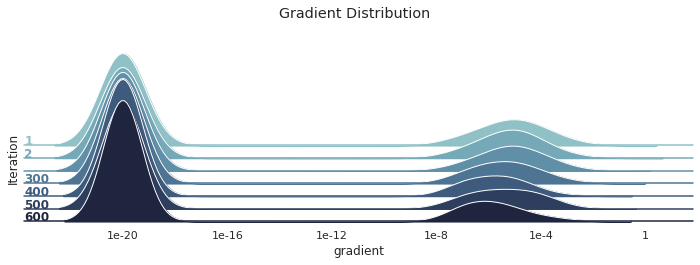

In [ ]:
grad_df = gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)